# DEEP LEANINNG MODEL - RESTNET-18 (CNN) - 128x128

In [9]:
# ================================
# Cell 0: WSL path helper + peek
# ================================
import os, platform, glob
from pathlib import PureWindowsPath

def is_wsl():
    try:
        return ("microsoft" in platform.release().lower()) or ("wsl" in platform.version().lower())
    except Exception:
        return False

def win_to_wsl_path(win_path: str) -> str:
    if not is_wsl(): return win_path
    if ":" not in win_path: return win_path
    p = PureWindowsPath(win_path)
    drive = str(p.drive).replace(":", "").lower()
    tail = str(p).replace("\\", "/").split(":/")[-1]
    return f"/mnt/{drive}/{tail}"

def peek_some_images(root, classes=("CNV","DME","DRUSEN","NORMAL"), max_show=3):
    print(f"\nPeeking into: {root}")
    for split in ("train","val","test"):
        split_dir = os.path.join(root, split)
        print(f"\n[{split}] exists: {os.path.isdir(split_dir)} -> {split_dir}")
        for cls in classes:
            cls_dir = os.path.join(split_dir, cls)
            imgs = []
            if os.path.isdir(cls_dir):
                for pat in ("*.png","*.jpg","*.jpeg","*.tif","*.bmp"):
                    imgs.extend(glob.glob(os.path.join(cls_dir, pat)))
            print(f"  {cls:<7} -> {len(imgs):6d} files | path: {cls_dir}")
            for s in imgs[:max_show]:
                print("    -", os.path.basename(s))

# --- Your Windows dataset path & save folder (edit if needed) ---
WIN_DATA_ROOT = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_128"
WIN_MODELS_DIR = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models"

DATA_ROOT   = win_to_wsl_path(WIN_DATA_ROOT)
MODELS_DIR  = win_to_wsl_path(WIN_MODELS_DIR)

print("Running in WSL:", is_wsl())
print("DATA_ROOT  ->", DATA_ROOT)
print("MODELS_DIR ->", MODELS_DIR)
peek_some_images(DATA_ROOT)


Running in WSL: True
DATA_ROOT  -> /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_128
MODELS_DIR -> /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/models

Peeking into: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_128

[train] exists: True -> /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_128/train
  CNV     ->  26216 files | path: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_128/train/CNV
    - CNV-1016042-1.png
    - CNV-1016042-10.png
    - CNV-1016042-100.png
  DME     ->   8116 files | path: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_128/train/DME
    - DME-1072015-1.png
    - DME-1072015-2.png
    - DME-1072015-3.png
  DRUSEN  ->   6201 files | path: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_128/train/DRUSEN
    - DRUSEN-1001666-4.png


In [10]:
# ================================
# Cell 1: Imports, device, seeds
# ================================
import time, copy, random, gc
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, datasets, models
from torch.amp import autocast, GradScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm
from PIL import Image

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available(): print("GPU:", torch.cuda.get_device_name(0))

# Reproducibility and stable kernels
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"


Torch: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA GeForce GTX 1650 Ti


In [11]:
# ================================
# Cell 2: Config & structure check
# ================================
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

EXPECTED_CLASSES = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Training config
IMG_SIZE      = 128
BATCH_SIZE    = 32
NUM_WORKERS   = 4
EPOCHS        = 10
LR            = 1e-4   # safer start
WEIGHT_DECAY  = 1e-4
LABEL_SMOOTH  = 0.0    # re-enable later if stable
MODEL_NAME    = "resnet18"   # "resnet18" | "resnet50" | "convnext_tiny"
PATIENCE      = 5

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("runs", exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

def check_structure(root, splits=("train","val","test"), classes=EXPECTED_CLASSES):
    problems = []
    for split in splits:
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path):
            problems.append(f"Missing split folder: {split_path}"); continue
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            if not os.path.isdir(cls_path):
                problems.append(f"Missing class folder: {cls_path}")
            else:
                files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path,f))]
                if not files: problems.append(f"No files in: {cls_path} (hydrate OneDrive?)")
    if problems:
        print("❌ Structure issues:")
        for p in problems: print(" -", p)
        raise FileNotFoundError("Fix dataset structure before continuing.")
    print("✅ Dataset structure looks good.")

check_structure(DATA_ROOT)


✅ Dataset structure looks good.


In [12]:
# ================================
# Cell 3: Datasets & transforms
# ================================
# Repeat grayscale → 3ch, resize, normalize
to_3 = transforms.Grayscale(num_output_channels=3)
resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])

base_train_t = transforms.Compose([
    to_3, resize,
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(), normalize
])

def heavy_aug_t():
    return transforms.Compose([
        to_3, resize,
        transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.4),
        transforms.RandomApply([transforms.RandomAffine(
            degrees=0, translate=(0.03,0.03), scale=(0.97,1.03))], p=0.4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.08, contrast=0.08)], p=0.25),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.15),
        transforms.ToTensor(), normalize
    ])

base_eval_t = transforms.Compose([to_3, resize, transforms.ToTensor(), normalize])

class ClassAwareImageFolder(Dataset):
    """ImageFolder with optional per-class transforms keyed by class name."""
    def __init__(self, root, default_transform, class_transforms=None):
        self.inner = datasets.ImageFolder(root=root)
        self.default_transform = default_transform
        self.class_transforms = class_transforms or {}
        self.name_to_idx = self.inner.class_to_idx
        self.idx_to_transform = {self.name_to_idx[n]: t
                                 for n, t in self.class_transforms.items()
                                 if n in self.name_to_idx}

    def __len__(self): return len(self.inner)
    def __getitem__(self, i):
        path, label = self.inner.samples[i]
        img = self.inner.loader(path)  # PIL image
        t = self.idx_to_transform.get(label, self.default_transform)
        img = t(img)
        return img, label

    @property
    def samples(self): return self.inner.samples
    @property
    def classes(self): return self.inner.classes
    @property
    def class_to_idx(self): return self.inner.class_to_idx

# Discover classes and counts
_tmp_train = datasets.ImageFolder(TRAIN_DIR)
_tmp_val   = datasets.ImageFolder(VAL_DIR)
_tmp_test  = datasets.ImageFolder(TEST_DIR)

class_names = _tmp_train.classes
assert sorted(class_names) == sorted(EXPECTED_CLASSES), "Classes on disk don't match EXPECTED_CLASSES."
print("Classes:", class_names)

def count_per_class(ds):
    cnt = Counter([y for _, y in ds.samples])
    return {class_names[i]: cnt[i] for i in range(len(class_names))}

print("Train counts:", count_per_class(_tmp_train))
print("Val counts  :", count_per_class(_tmp_val))
print("Test counts :", count_per_class(_tmp_test))

# Heavier augmentation for minority classes
_train_cnt = count_per_class(_tmp_train)
median_count = sorted(_train_cnt.values())[len(_train_cnt)//2]
minority_names = [k for k, v in _train_cnt.items() if v <= median_count]
print("Minority classes (heavier aug):", minority_names)

train_ds = ClassAwareImageFolder(
    TRAIN_DIR, default_transform=base_train_t,
    class_transforms={name: heavy_aug_t() for name in minority_names}
)
val_ds   = ClassAwareImageFolder(VAL_DIR,  default_transform=base_eval_t)
test_ds  = ClassAwareImageFolder(TEST_DIR, default_transform=base_eval_t)

# Weighted sampler for class imbalance (TRAIN only)
train_labels = [y for _, y in train_ds.samples]
class_count_map = Counter(train_labels)
sample_weights = [1.0 / class_count_map[y] for y in train_labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

def worker_init_fn(worker_id): np.random.seed(SEED + worker_id)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True, worker_init_fn=worker_init_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# Expose class info
NUM_CLASSES = len(class_names)
print("NUM_CLASSES:", NUM_CLASSES)

# Quick sanity on batches
for i, (xb, yb) in enumerate(DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)):
    ok = torch.isfinite(xb).all() and xb.std() > 0
    print(f"[sanity batch {i}] finite={bool(torch.isfinite(xb).all())} std={xb.std().item():.4f}")
    if i == 2: break


Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Train counts: {'CNV': 26216, 'DME': 8116, 'DRUSEN': 6201, 'NORMAL': 18593}
Val counts  : {'CNV': 5618, 'DME': 1739, 'DRUSEN': 1329, 'NORMAL': 3984}
Test counts : {'CNV': 5617, 'DME': 1739, 'DRUSEN': 1329, 'NORMAL': 3984}
Minority classes (heavier aug): ['DME', 'DRUSEN', 'NORMAL']
NUM_CLASSES: 4
[sanity batch 0] finite=True std=0.6416
[sanity batch 1] finite=True std=0.6565
[sanity batch 2] finite=True std=0.6727


In [13]:
# ================================
# Cell 4: Model builder
# ================================
def build_model(num_classes, name="resnet18"):
    if name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    elif name == "resnet50":
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        m.fc = nn.Linear(m.fc.in_features, num_classes)
    elif name == "convnext_tiny":
        m = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
        m.classifier[-1] = nn.Linear(m.classifier[-1].in_features, num_classes)
    else:
        raise ValueError(f"Unsupported MODEL_NAME: {name}")
    return m


In [14]:
# ================================
# Cell 5: Train/Eval helpers
# ================================
USE_AMP   = True   # set False if you still see NaNs
MAX_NORM  = 5.0    # gradient clipping

@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(1)
        all_y.append(y.cpu().numpy()); all_p.append(preds.cpu().numpy())
    y_true = np.concatenate(all_y); y_pred = np.concatenate(all_p)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    return acc, macro_f1, cm, y_true, y_pred

def batch_ok(x, y):
    if not torch.isfinite(x).all(): return False, "inputs contain inf/nan"
    if y.dtype != torch.long:      return False, f"targets dtype {y.dtype} != long"
    if (y < 0).any() or (y >= NUM_CLASSES).any(): return False, "target out of range"
    return True, "ok"

def train_one_epoch(model, loader, optimizer, scaler, criterion):
    model.train()
    running_loss, seen = 0.0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)

        ok, why = batch_ok(x, y)
        if not ok:
            print("Bad batch:", why); continue

        optimizer.zero_grad(set_to_none=True)

        if USE_AMP:
            with autocast(device_type='cuda' if DEVICE=='cuda' else 'cpu'):
                logits = model(x)
                if not torch.isfinite(logits).all():
                    print("Logits inf/nan; skipping batch")
                    continue
                loss = F.cross_entropy(logits, y)  # start without label smoothing
            if not torch.isfinite(loss):
                print("Loss inf/nan before backward; skipping batch")
                continue
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            if not torch.isfinite(logits).all():
                print("Logits inf/nan; skipping batch")
                continue
            loss = F.cross_entropy(logits, y)
            if not torch.isfinite(loss):
                print("Loss inf/nan before backward; skipping batch")
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
            optimizer.step()

        running_loss += loss.item() * x.size(0)
        seen += x.size(0)
    return running_loss / max(1, seen)

def plot_history(history, save_prefix=None):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], 'b-o', label="Train Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss Curve"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_acc"], 'g-o', label="Val Accuracy")
    plt.plot(epochs, history["val_f1"],  'r-o', label="Val F1")
    plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Validation Accuracy & F1"); plt.legend()
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_curves.png", dpi=200, bbox_inches="tight")
    plt.show()

def save_checkpoint(model_state, classes, epoch, val_acc, val_f1, prefix):
    ckpt = {
        "model_state": model_state,
        "classes": classes,
        "epoch": epoch,
        "val_acc": float(val_acc),
        "val_f1": float(val_f1),
        "config": {"MODEL_NAME": MODEL_NAME, "IMG_SIZE": IMG_SIZE,
                   "BATCH_SIZE": BATCH_SIZE, "LR": LR, "WEIGHT_DECAY": WEIGHT_DECAY}
    }
    path = f"checkpoints/{prefix}.pth"
    torch.save(ckpt, path)
    torch.save(ckpt, os.path.join(MODELS_DIR, f"{prefix}.pth"))  # mirror to Windows folder
    return path

Epoch 01 | loss 0.3260 | val_acc 0.9390 | val_f1 0.9090 | lr 9.76e-05 | 433.2s
  ↳ Saved best checkpoint to: checkpoints/resnet18_best.pth


Epoch 02 | loss 0.1994 | val_acc 0.9292 | val_f1 0.9064 | lr 9.05e-05 | 427.4s


Epoch 03 | loss 0.1658 | val_acc 0.9399 | val_f1 0.9166 | lr 7.94e-05 | 426.9s
  ↳ Saved best checkpoint to: checkpoints/resnet18_best.pth


Epoch 04 | loss 0.1443 | val_acc 0.9486 | val_f1 0.9285 | lr 6.55e-05 | 426.4s
  ↳ Saved best checkpoint to: checkpoints/resnet18_best.pth


Epoch 05 | loss 0.1204 | val_acc 0.9531 | val_f1 0.9345 | lr 5.00e-05 | 426.6s
  ↳ Saved best checkpoint to: checkpoints/resnet18_best.pth


Epoch 06 | loss 0.1046 | val_acc 0.9526 | val_f1 0.9337 | lr 3.45e-05 | 426.1s


Epoch 07 | loss 0.0858 | val_acc 0.9536 | val_f1 0.9359 | lr 2.06e-05 | 430.6s
  ↳ Saved best checkpoint to: checkpoints/resnet18_best.pth


Epoch 08 | loss 0.0734 | val_acc 0.9642 | val_f1 0.9481 | lr 9.55e-06 | 436.3s
  ↳ Saved best checkpoint to: checkpoints/resnet18_best.pth


Epoch 09 | loss 0.0661 | val_acc 0.9642 | val_f1 0.9487 | lr 2.45e-06 | 427.4s
  ↳ Saved best checkpoint to: checkpoints/resnet18_best.pth


Epoch 10 | loss 0.0582 | val_acc 0.9635 | val_f1 0.9478 | lr 0.00e+00 | 414.5s


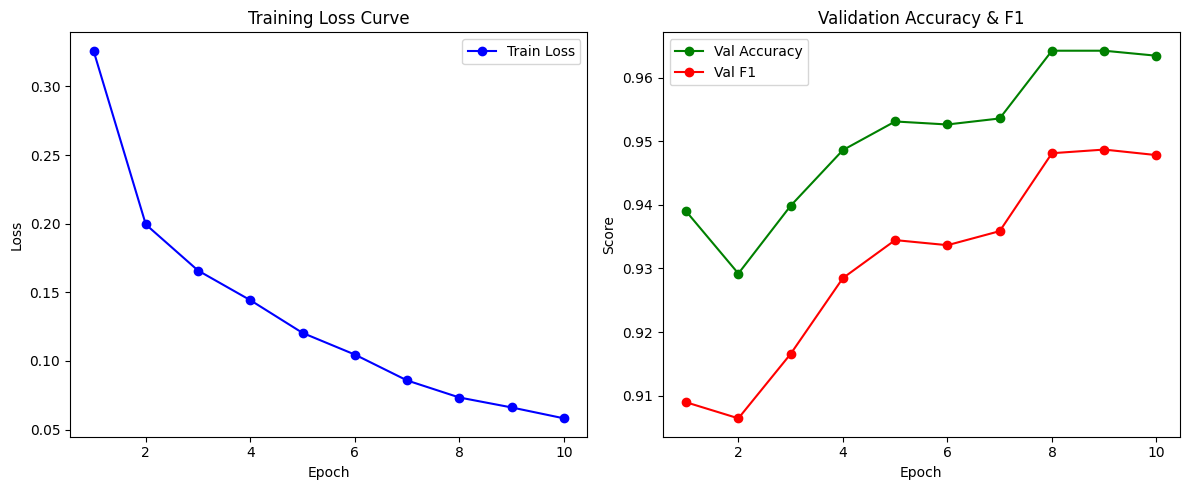

Best @ epoch 9: val_acc=0.9642 | val_f1=0.9487


In [15]:
# ================================
# Cell 6: Train
# ================================
model = build_model(num_classes=NUM_CLASSES, name=MODEL_NAME).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = GradScaler(enabled=USE_AMP)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)

history = {"train_loss": [], "val_acc": [], "val_f1": []}
best_state, best_f1, best_acc, best_epoch = None, -1.0, -1.0, 0
bad = 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, scaler, criterion)
    val_acc, val_f1, val_cm, yv, pv = evaluate(val_loader, model)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    print(f"Epoch {epoch:02d} | loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | lr {scheduler.get_last_lr()[0]:.2e} | {time.time()-t0:.1f}s")

    if val_f1 > best_f1:
        best_f1, best_acc, best_epoch = val_f1, val_acc, epoch
        best_state = copy.deepcopy(model.state_dict())
        ck_path = save_checkpoint(best_state, class_names, epoch, val_acc, val_f1, f"{MODEL_NAME}_best")
        print("  ↳ Saved best checkpoint to:", ck_path)
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE:
            print("  ↳ Early stopping.")
            break

plot_history(history, save_prefix=f"runs/{MODEL_NAME}_trainval")
print(f"Best @ epoch {best_epoch}: val_acc={best_acc:.4f} | val_f1={best_f1:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)



=== TEST RESULTS ===
Accuracy : 0.9635
Macro F1 : 0.9475

Classification Report:
              precision    recall  f1-score   support

         CNV     0.9809    0.9769    0.9789      5617
         DME     0.9655    0.9655    0.9655      1739
      DRUSEN     0.8591    0.8901    0.8744      1329
      NORMAL     0.9745    0.9684    0.9714      3984

    accuracy                         0.9635     12669
   macro avg     0.9450    0.9502    0.9475     12669
weighted avg     0.9640    0.9635    0.9637     12669



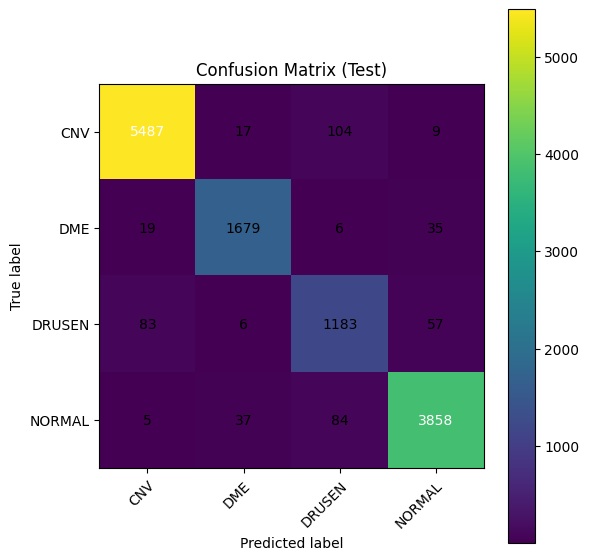

In [16]:
# ================================
# Cell 7: Test evaluation & reports
# ================================
test_acc, test_f1, test_cm, y_true, y_pred = evaluate(test_loader, model)

print("\n=== TEST RESULTS ===")
print("Accuracy :", round(test_acc, 4))
print("Macro F1 :", round(test_f1, 4))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix Plot (and save)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(test_cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(class_names)), yticks=np.arange(len(class_names)),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label', xlabel='Predicted label', title='Confusion Matrix (Test)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
thresh = test_cm.max() / 2.
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax.text(j, i, format(test_cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if test_cm[i, j] > thresh else "black")
plt.tight_layout()
plt.savefig("runs/confusion_matrix_test.png", dpi=200, bbox_inches="tight")
plt.show()



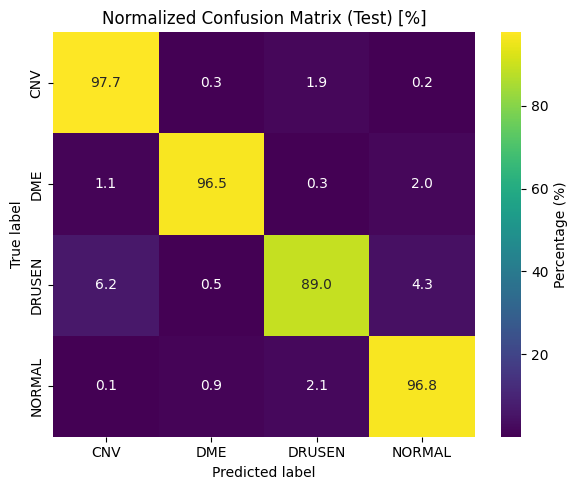

[SAVED] C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models\confusion_matrix_test_normalized.png


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example confusion matrix (your values)
cm = np.array([
    [5487,  17, 104,   9],
    [  19, 1679,  6,  35],
    [  83,   6, 1183, 57],
    [   5,  37,  84, 3858]
])

CLASSES = ["CNV", "DME", "DRUSEN", "NORMAL"]

# --- Convert to percentage (row-wise normalization) ---
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot normalized confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="viridis",
            xticklabels=CLASSES, yticklabels=CLASSES, cbar_kws={'label': 'Percentage (%)'})
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix (Test) [%]")
plt.tight_layout()
plt.show()



plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="viridis",
            xticklabels=CLASSES, yticklabels=CLASSES, cbar_kws={'label': 'Percentage (%)'})
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix (Test) [%]")
plt.tight_layout()
plt.savefig(out_path, dpi=300)
plt.close()
print(f"[SAVED] {out_path}")


/home/sheno/tf/lib/python3.12/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


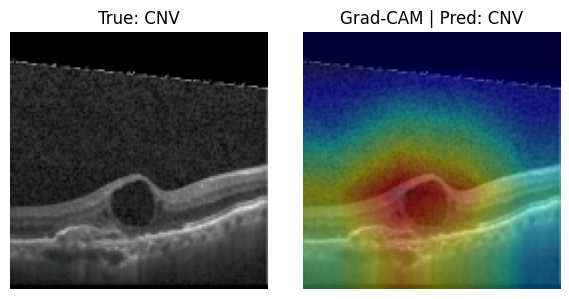

Saved: runs/gradcam/gradcam_CNV_1.png


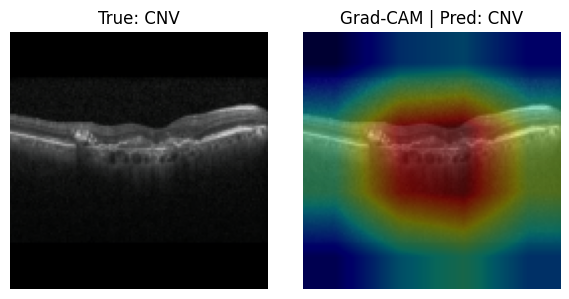

Saved: runs/gradcam/gradcam_CNV_2.png


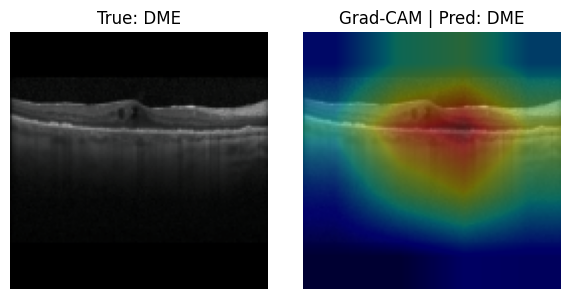

Saved: runs/gradcam/gradcam_DME_1.png


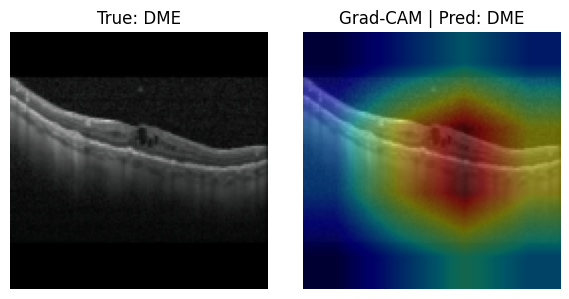

Saved: runs/gradcam/gradcam_DME_2.png


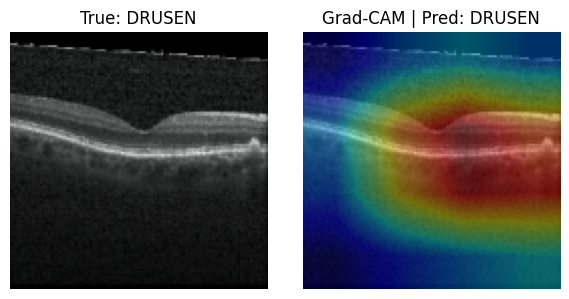

Saved: runs/gradcam/gradcam_DRUSEN_1.png


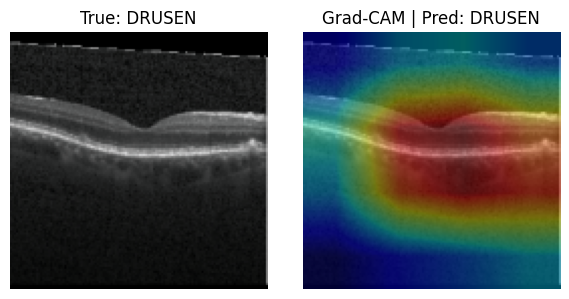

Saved: runs/gradcam/gradcam_DRUSEN_2.png


In [17]:
# ================================
# Cell 8: Grad-CAM (optional)
# ================================
def get_target_layer(m, name):
    if name.startswith("resnet"):
        block = m.layer4[-1]
        return block.conv3 if hasattr(block, "conv3") else block.conv2
    elif name == "convnext_tiny":
        return m.features[-1][-1].dwconv
    else:
        raise ValueError(f"Grad-CAM layer not defined for {name}")

target_layer = get_target_layer(model, MODEL_NAME)
_activ, _grads = {}, {}

def _fwd_hook(_, __, output): _activ["value"] = output.detach()
def _bwd_hook(_, grad_in, grad_out): _grads["value"] = grad_out[0].detach()
h_fwd = target_layer.register_forward_hook(_fwd_hook)
h_bwd = target_layer.register_backward_hook(_bwd_hook)

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denorm_to_uint8(t):
    x = t.permute(1,2,0).cpu().numpy()
    x = (x * IMAGENET_STD + IMAGENET_MEAN); x = np.clip(x, 0, 1)
    return (x*255).astype(np.uint8)

def gradcam_map(x1, class_idx=None):
    model.eval(); _activ.clear(); _grads.clear()
    out = model(x1)
    if class_idx is None: class_idx = out.argmax(1).item()
    score = out[0, class_idx]
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=True)
    A = _activ["value"]; dA = _grads["value"]
    weights = dA.mean(dim=(2,3), keepdim=True)
    cam = (weights * A).sum(dim=1)
    cam = F.relu(cam)[0]
    cam = cam - cam.min()
    if cam.max() > 0: cam = cam / cam.max()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=x1.shape[-2:], mode="bilinear", align_corners=False)
    return cam[0,0].cpu().numpy()

def overlay_heatmap(img_uint8, cam, alpha=0.4):
    from matplotlib import cm
    heat = (cm.jet(cam)[..., :3] * 255).astype(np.uint8)
    return (alpha*heat + (1-alpha)*img_uint8).astype(np.uint8)

def save_gradcam_examples(ds, classes=("CNV","DME","DRUSEN"), k=2, out_dir="runs/gradcam"):
    os.makedirs(out_dir, exist_ok=True)
    for cname in classes:
        cidx = class_names.index(cname)
        idxs = [i for i, (_, y) in enumerate(ds.samples) if y == cidx][:k]
        for j, i in enumerate(idxs, start=1):
            path, y = ds.samples[i]
            img_t, _ = ds[i]
            x = img_t.unsqueeze(0).to(DEVICE)
            cam = gradcam_map(x)
            img_vis = denorm_to_uint8(img_t)
            overlay = overlay_heatmap(img_vis, cam)
            plt.figure(figsize=(6,3))
            plt.subplot(1,2,1); plt.imshow(img_vis); plt.axis("off"); plt.title(f"True: {class_names[y]}")
            pred = model(x).argmax(1).item()
            plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off"); plt.title(f"Grad-CAM | Pred: {class_names[pred]}")
            fname = os.path.join(out_dir, f"gradcam_{cname}_{j}.png")
            plt.tight_layout(); plt.savefig(fname, dpi=200, bbox_inches="tight"); plt.show()
            print("Saved:", fname)

# Run a few Grad-CAM samples from test
save_gradcam_examples(test_ds, classes=("CNV","DME","DRUSEN"), k=2, out_dir="runs/gradcam")

# cleanup hooks
h_fwd.remove(); h_bwd.remove()


In [19]:
# ================================
# Cell 9: Save final weights (.pth + .pkl)
# ================================
import pickle
state = model.state_dict()
pth_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_oct2017_final_128_weights.pth")
pkl_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_oct2017_final_128_weights.pkl")
torch.save(state, pth_path)
with open(pkl_path, "wb") as f: pickle.dump(state, f)
print("Saved:", pth_path)
print("Saved:", pkl_path)


Saved: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/models/resnet18_oct2017_final_128_weights.pth
Saved: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/models/resnet18_oct2017_final_128_weights.pkl
